<a href="https://colab.research.google.com/github/EA-b13/LULC_L3_Analysis/blob/main/Final_Step2_Level3_Cluster_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This script is used to run hierarchical clustering to obtain representative cluster centroids for all cropping intensity classes.

The classes used are:
*   Single Kharif
*   Single Non Kharif
*   Double Cropping
*   Triple Cropping
*   Others

The script also displays the 5-95 and 25-75 quantile covers for each cluster obtained. The distribution of distance to assigned cluster centroid for each cluster is visualized and quantified using mean, standard deviation and mean distortion.



# Create Environment

## Library installations

In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Move to working directory
! cd /content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat

In [ ]:
# ! pwd

## Module Imports

In [ ]:
from pprint import pprint
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
import numpy
import matplotlib.pyplot as plt
import json
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import os
from matplotlib.pyplot import figure
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function Definitions

In [ ]:
def convert_df_to_tsdf(df, COLUMNS):
  ts_dataset = df[COLUMNS].to_numpy()
  ts_dataset = ts_dataset.reshape(*ts_dataset.shape, 1)
  return ts_dataset


# Load initial k-means clustering checkpoint
def get_clusters_from_checkpoint(KM_PATH):
  with open(KM_PATH, 'rb') as f:
    km = pickle.load(f)
    NUM_CLUSTERS = len(km.cluster_centers_.squeeze())

  return km, NUM_CLUSTERS


# Initial clustering
def get_initial_clusters(ts_dataset, NUM_CLUSTERS, seed):
  km = TimeSeriesKMeans(n_clusters=NUM_CLUSTERS, metric="euclidean", n_jobs=32, verbose=False, random_state=seed)
  km.fit(ts_dataset)

  return km


# Hierarchical clustering
def get_hierarchical_clusters(ts_dataset, km, NUM_CLUSTERS, THRESHOLD, N_CLUSTER_SPLIT, seed):
  centroids = []
  data_splits = []
  data_to_process = [ts_dataset]
  centroids_to_process = [km.cluster_centers_.squeeze()]
  # print("centroids_to_process",len(centroids_to_process))
  y_to_process = [km.predict(ts_dataset)]
  num_to_process = [NUM_CLUSTERS]

  while len(data_to_process) > 0:
    data = data_to_process.pop(0)
    rel_centroids = centroids_to_process.pop(0)
    y_pred = y_to_process.pop(0)
    num_clusters = num_to_process.pop(0)
    for _ in range(num_clusters):
      print(f'Processing Cluster {_}')
      relevant_data = data[y_pred == _]
      dist_data = relevant_data.squeeze()
      centroid = rel_centroids[_]
      distances = np.linalg.norm(dist_data - centroid, axis=-1)
      distortion = np.mean((distances)**2)
      if (distortion <= THRESHOLD):
        centroids.append(centroid)
        data_splits.append(dist_data)
      else:
        km_split = TimeSeriesKMeans(n_clusters=N_CLUSTER_SPLIT, metric="euclidean", n_jobs=32, verbose=False, random_state=seed)
        y_pred_new = km_split.fit_predict(relevant_data)
        num_to_process.append(N_CLUSTER_SPLIT)
        data_to_process.append(relevant_data)
        y_to_process.append(y_pred_new)
        centroids_to_process.append(km_split.cluster_centers_.squeeze())
    print('After Popping: ' + str(len(data_to_process)))

  return centroids, data_splits


# Hierarchical clustering
def break_target_clusters(centroids, data_splits, target_cluster_list, seed):
  final_centroids = []
  final_data_splits = []

  for cluster_id in range( len(centroids) ):
    # print("Currently at: ",cluster_id)
    if cluster_id in target_cluster_list:
      # print(f'Processing Cluster {cluster_id+1}')
      curr_data = data_splits[cluster_id]
      km_split = TimeSeriesKMeans(n_clusters=2, metric="euclidean", n_jobs=32, verbose=False, random_state=seed)
      y_pred_new = km_split.fit_predict( curr_data )
      new_centroids = km_split.cluster_centers_.squeeze()
      for new_cluster_id in range(2):
        curr_split = curr_data[y_pred_new == new_cluster_id]
        curr_split = curr_split.squeeze()
        # print("Data Split: ", curr_split.shape )
        final_data_splits.append(curr_split)
        curr_centroid = new_centroids[new_cluster_id]
        final_centroids.append(curr_centroid)
      # print(" centroid array after append: ", final_centroids)
    else:
      final_centroids.append( centroids[cluster_id] )
      final_data_splits.append( data_splits[cluster_id] )

  return final_centroids, final_data_splits


def display_clusters(centroids, data_splits, sz):
  figure(figsize=(50, 20), dpi=80)
  splits = 5
  # splits = math.ceil( int( len(centroids)/10 ) )
  n_plots = len(centroids)
  print("Number of centroids are: ",n_plots)
  for idx, centroid in enumerate(centroids):
      try:
        ax = plt.subplot(splits, (n_plots+splits-1)//splits, idx + 1)

        plt.rc('font', size=16)
        plt.rc('xtick', labelsize=14)
        plt.rc('ytick', labelsize=14)

        consider = data_splits[idx].squeeze()
        centroid = centroid.squeeze()
        distances = np.linalg.norm(consider - centroid, axis=-1)
        quantiles = [np.quantile(distances, _) for _ in [.05, .25, .75, .95]]
        first_q = consider[(distances >= quantiles[0]) & (distances <= quantiles[-1])]
        first_q_top = first_q.max(axis=0)
        first_q_bot = first_q.min(axis=0)
        plt.fill_between(np.arange(23), first_q_top, first_q_bot, color='blue', alpha=0.2)
        second_q = consider[(distances >= quantiles[1]) & (distances <= quantiles[-2])]
        second_q_top = second_q.max(axis=0)
        second_q_bot = second_q.min(axis=0)
        plt.fill_between(np.arange(23), second_q_top, second_q_bot, color='blue', alpha=0.5)
        plt.plot(centroid, "r-")
        plt.xlim(0, sz)
        plt.ylim(-1.2, 1.5)
        plt.axhline(y=0.3, color='g', linestyle='--', label='NDVI value 0.35')
        plt.text(0.55, 0.85,'Cluster %d' % (idx + 1),
                transform=plt.gca().transAxes)
        if idx == 4:
            plt.title("Euclidean $k$-means")

        ax.xaxis.set_ticks(np.arange(start=0, stop=23, step=4))
      except Exception as e:
        print(e)


# Find the optimal number of clusters using the elbow method
def get_elbow_silhouette_plot(X, min_clusters, max_clusters):
  inertia = []
  silhouette_scores = []
  for k in range(min_clusters, max_clusters):
      kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
      kmeans.fit(X)
      inertia.append(kmeans.inertia_)
      cluster_labels = kmeans.fit_predict(X)
      silhouette_avg = silhouette_score(X, cluster_labels)
      silhouette_scores.append(silhouette_avg)

  # Plot the elbow curve
  plt.figure(figsize=(20, 6))
  plt.plot(range(min_clusters, max_clusters), inertia, marker='o')
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.xticks(np.arange(min_clusters, max_clusters))
  plt.grid(True)
  plt.show()

  # Plot silhouette scores
  plt.figure(figsize=(20, 6))
  plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o')
  plt.title('Silhouette Score for Different Numbers of Clusters')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.xticks(np.arange(min_clusters, max_clusters))
  plt.grid(True)
  plt.show()



# Original Pan-India Clustering

<ipython-input-7-848a97864b13>:9: DtypeWarning: Columns (26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_PATH)


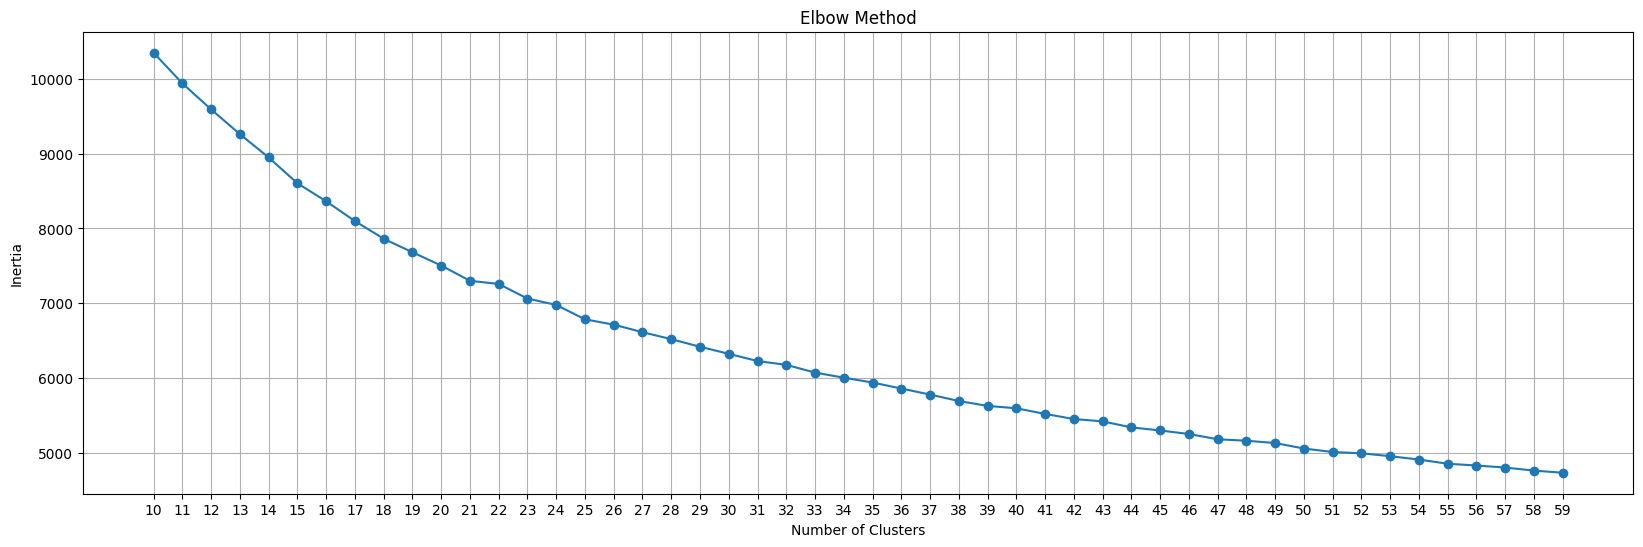

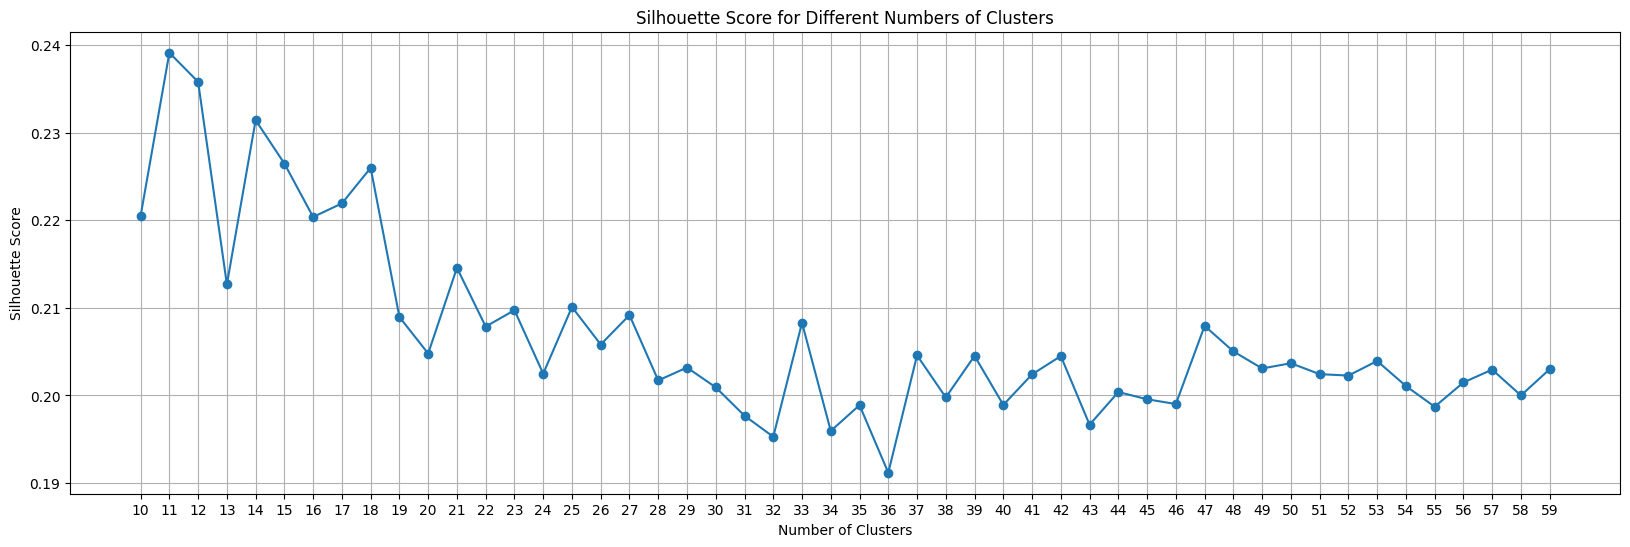

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Non_Padded_Original_NDVI_LSC_TS_2018_19_C2.csv'

COLUMNS = []
for i in range(0, 23):
    label = str(i) + "_gapfilled_NDVI_lsc"
    COLUMNS.append(label)

# Read dataframe
df = pd.read_csv(INPUT_PATH)
df = df[COLUMNS]

get_elbow_silhouette_plot(df, 10, 60)

In [ ]:
# input_path = Non_Padded_Original/Non_Padded_Original_NDVI_TS.csv
base_path = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Non_Padded_Original_NDVI_TS_2016_17.csv'

choice = input("\n Do you want to load initial K-Means Clustering checkpoint?  \n 1. Yes \n 2. No \n")
if (choice == '1'):
  KM_PATH = input("\n Give path to K-Means checkpoint: \t")
else:
  NUM_CLUSTERS = int(input("\n Set Number of Clusters for Initial Clustering (Recommended: 16): \t"))

THRESHOLD = float(input("\n Set Distortion Threshold for Hierarchical Step (Recommended: 0.25): \t"))
N_CLUSTER_SPLIT = int(input("\n Set Number of Clusters to be used in Hierarchical Step (Recommended: 2): \t"))
sub_path = input("\n Give path to Training Data: \t")
INPUT_PATH = base_path + '/' + sub_path

COLUMNS = []
for i in range(0, 23):
    label = str(i) + "_gapfilled_NDVI_lsc"
    COLUMNS.append(label)

KeyboardInterrupt: ignored

<ipython-input-8-c1e9e0fbf17d>:13: DtypeWarning: Columns (26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_PATH)


Number of Clusters: 21
Processing Cluster 0
Processing Cluster 1
Processing Cluster 2
Processing Cluster 3
Processing Cluster 4
Processing Cluster 5
Processing Cluster 6
Processing Cluster 7
Processing Cluster 8
Processing Cluster 9
Processing Cluster 10
Processing Cluster 11
Processing Cluster 12
Processing Cluster 13
Processing Cluster 14
Processing Cluster 15
Processing Cluster 16
Processing Cluster 17
Processing Cluster 18
Processing Cluster 19
Processing Cluster 20
After Popping: 3
Processing Cluster 0
Processing Cluster 1
After Popping: 3
Processing Cluster 0
Processing Cluster 1
After Popping: 3
Processing Cluster 0
Processing Cluster 1
After Popping: 4
Processing Cluster 0
Processing Cluster 1
After Popping: 4
Processing Cluster 0
Processing Cluster 1
After Popping: 3
Processing Cluster 0
Processing Cluster 1
After Popping: 2
Processing Cluster 0
Processing Cluster 1
After Popping: 3
Processing Cluster 0
Processing Cluster 1
After Popping: 3
Processing Cluster 0
Processing Clus

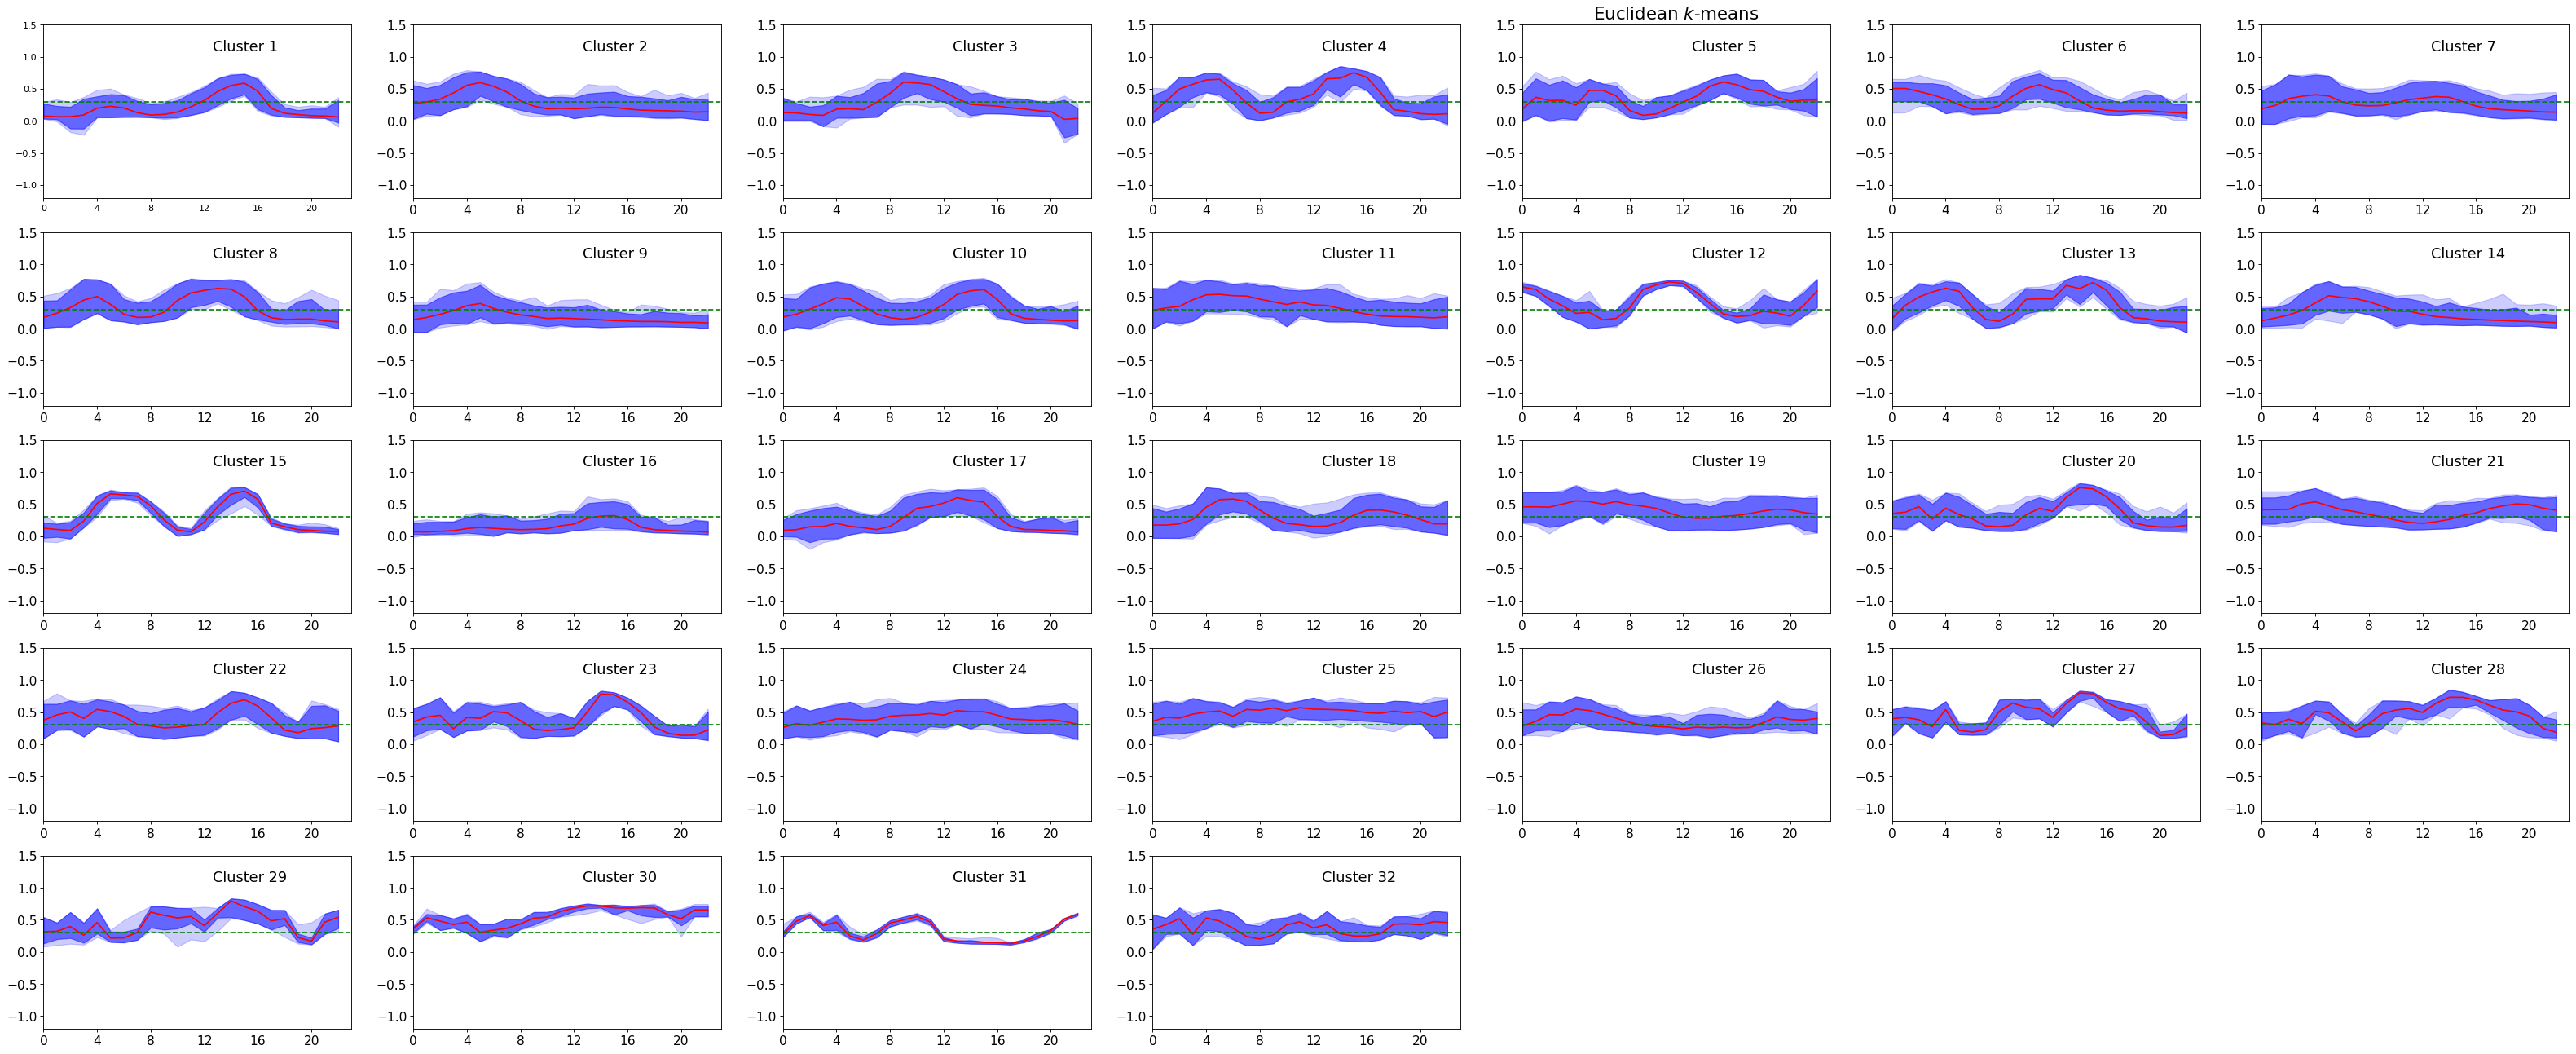

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Non_Padded_Original_NDVI_LSC_TS_2018_19_C2.csv'
choice = 2
NUM_CLUSTERS = 21
THRESHOLD = 0.26
N_CLUSTER_SPLIT = 2

COLUMNS = []
for i in range(0, 23):
  label = str(i) + "_gapfilled_NDVI_lsc"
  COLUMNS.append(label)

# Read dataframe
df = pd.read_csv(INPUT_PATH)
df = df[COLUMNS]

ts_dataset = convert_df_to_tsdf(df, COLUMNS)

if (choice == '1'):
  km, NUM_CLUSTERS = get_clusters_from_checkpoint(KM_PATH)
else:
  km = get_initial_clusters(ts_dataset, NUM_CLUSTERS, seed=0)
  print("Number of Clusters:", len(np.unique(km.labels_)))

centroids, data_splits = get_hierarchical_clusters(ts_dataset, km, NUM_CLUSTERS, THRESHOLD, N_CLUSTER_SPLIT, seed=0)

display_clusters(centroids, data_splits, sz=ts_dataset.shape[1])

Number of centroids are:  34


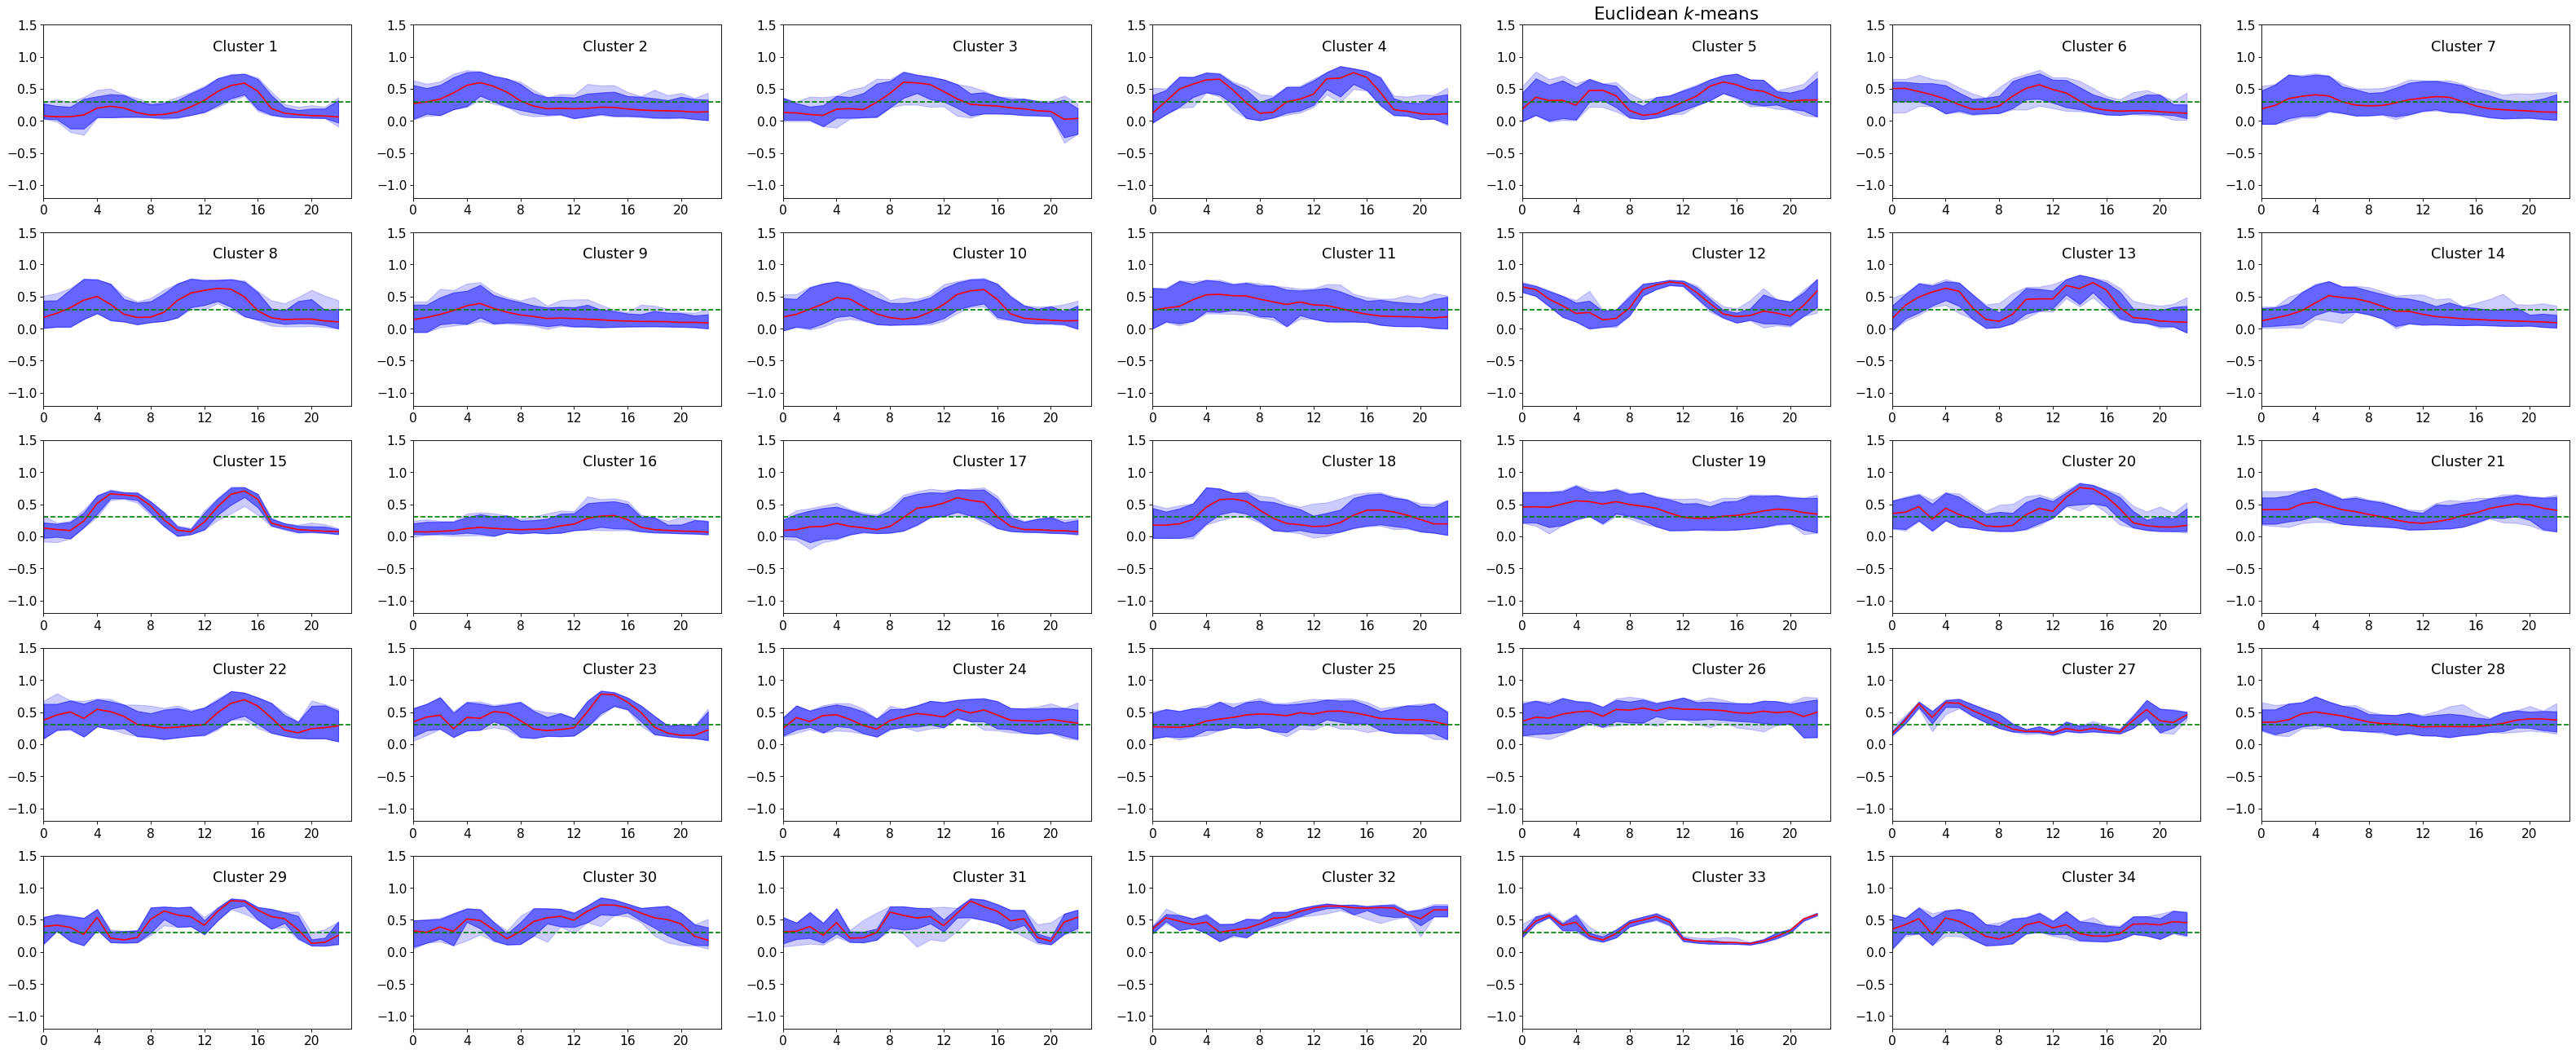

In [ ]:
# target_cluster_list = [2, 5, 8, 12, 16, 17, 18, 19, 22, 23, 24, 28, 31, 33, 35, 39, 41, 44] #for distortion 0.2
# target_cluster_list = [1, 2, 5, 8, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33]
target_cluster_list = [24,26]

modified_list = [x - 1 for x in target_cluster_list]

new_centroids, new_data_splits = break_target_clusters(centroids, data_splits, modified_list, seed=0)

display_clusters(new_centroids, new_data_splits, sz=ts_dataset.shape[1])

In [ ]:
# mapping = input("Enter class mapping for all clusters as space separated list \t")
# mapping = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
# mapping = 11 9 11 11 11 11 11 9 11 11 9 11 11 11 8 9 11 12 12 11 12 12 12 11 8 12 11 12 8 12 11 11
# mapping = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
# mapping = 8 8 11 8 11 11 10 8 11 11 8 9 11 9 9 11 8 8 8 11 9 9 11 8 8 8 11 8 8 12 12 12 8 8 8 12 12 13 12 8 13 12 12 8 8 8 8 12 11 8 8 8 12 12 12
'''
8 - SK
9 - SNK
10 - Double
11 - Triple
12 - Invalid
'''
mapping = "9 8 9 10 11 10 10 10 8 10 8 11 10 8 10 9 9 10 10 10 10 11 11 10 12 11 11 12 11 11 11 11 11 11"
# mapping = "1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41"

df = pd.DataFrame(np.array(new_centroids), columns=[f'{_}_gapfilled_NDVI_lsc' for _ in range(23)])

cluster_mapping = numpy.array([int(_) for _ in mapping.strip().split()])

labels = pd.Series(cluster_mapping, name= 'class')
df = pd.concat([df, labels], axis=1)

# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Non_Padded_Original_Clusters.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Non_Padded_Original_18Clusters_2distortion.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Non_Padded_Original_18Clusters_23distortion_afterCustomization.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Test_clusters.csv'
out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Final_Level3_PanIndia_Clusters_LSC_C2_2018_19.csv'
df.to_csv(out_path, index=False)

# Original Pan-India Clustering LC Only

<ipython-input-7-fded726ab445>:9: DtypeWarning: Columns (26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_PATH)


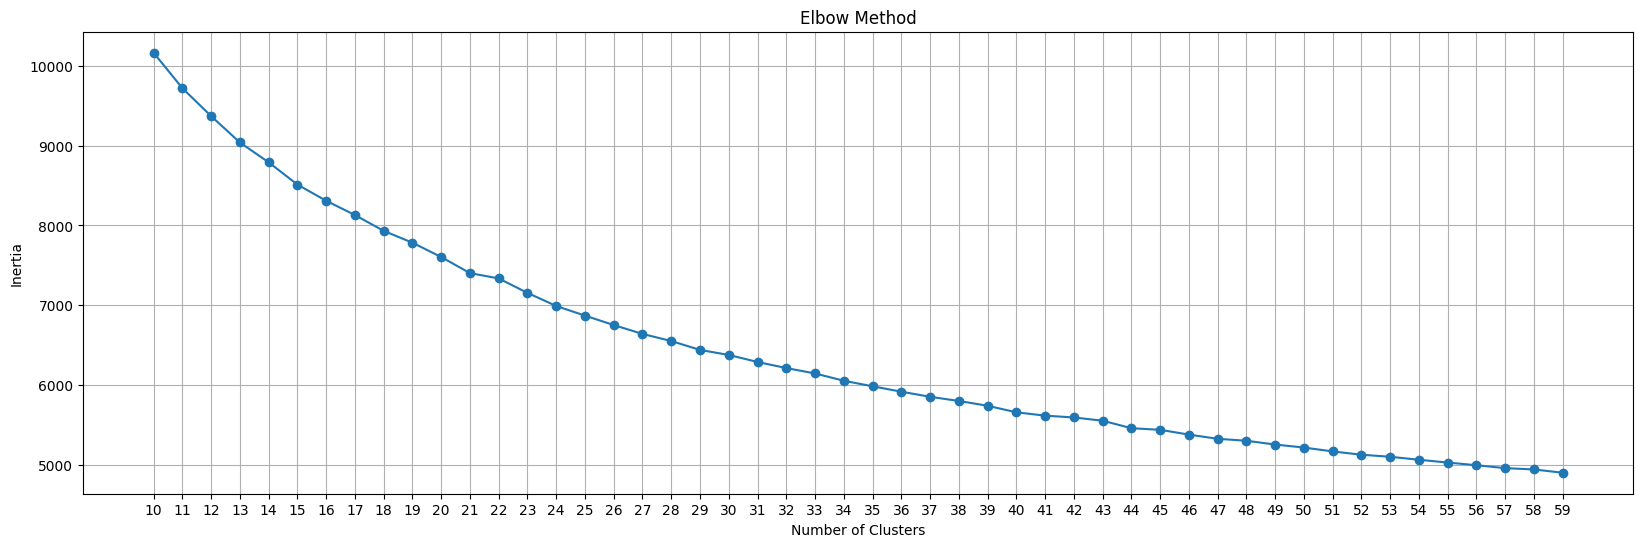

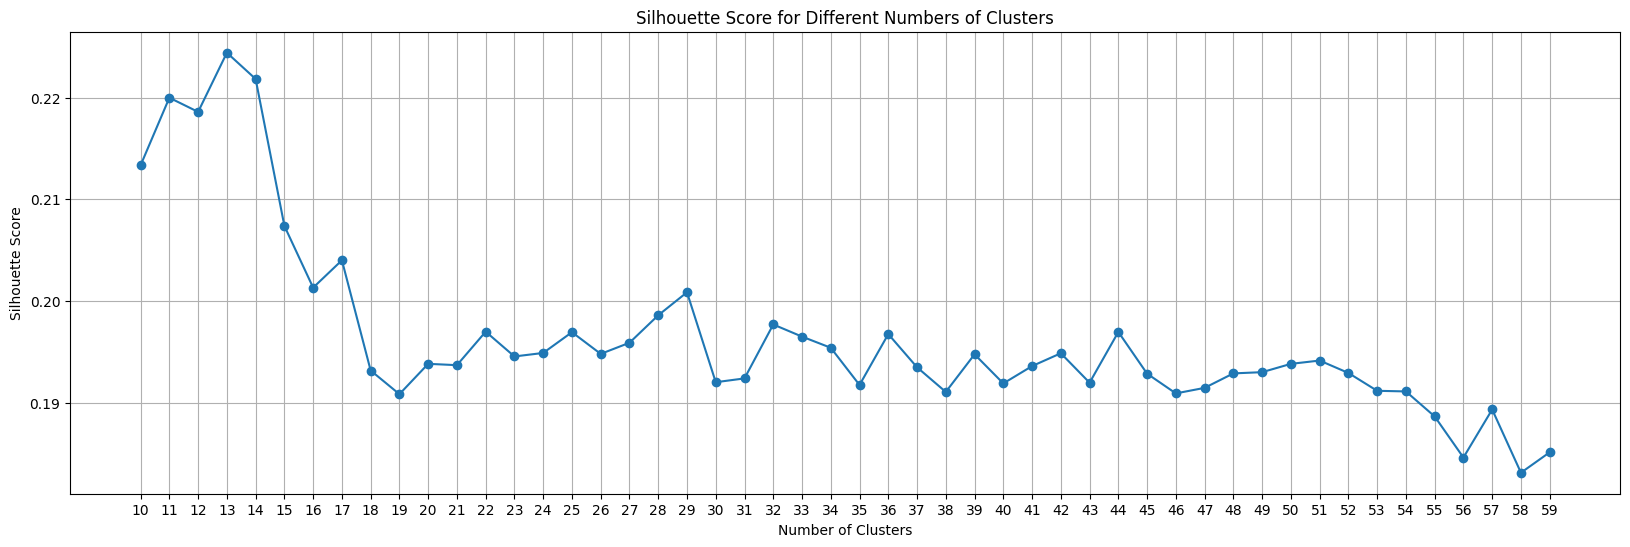

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Non_Padded_Original_NDVI_TS_L7_only.csv'

COLUMNS = []
for i in range(0, 23):
    label = str(i) + "_gapfilled_NDVI_lsc"
    COLUMNS.append(label)

# Read dataframe
df = pd.read_csv(INPUT_PATH)
df = df[COLUMNS]

get_elbow_silhouette_plot(df, 10, 60)

<ipython-input-10-3ddeb33a0454>:13: DtypeWarning: Columns (26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_PATH)


Number of Clusters: 21
Processing Cluster 0
Processing Cluster 1
Processing Cluster 2
Processing Cluster 3
Processing Cluster 4
Processing Cluster 5
Processing Cluster 6
Processing Cluster 7
Processing Cluster 8
Processing Cluster 9
Processing Cluster 10
Processing Cluster 11
Processing Cluster 12
Processing Cluster 13
Processing Cluster 14
Processing Cluster 15
Processing Cluster 16
Processing Cluster 17
Processing Cluster 18
Processing Cluster 19
Processing Cluster 20
After Popping: 1
Processing Cluster 0
Processing Cluster 1
After Popping: 1
Processing Cluster 0
Processing Cluster 1
After Popping: 2
Processing Cluster 0
Processing Cluster 1
After Popping: 1
Processing Cluster 0
Processing Cluster 1
After Popping: 0
Number of centroids are:  25


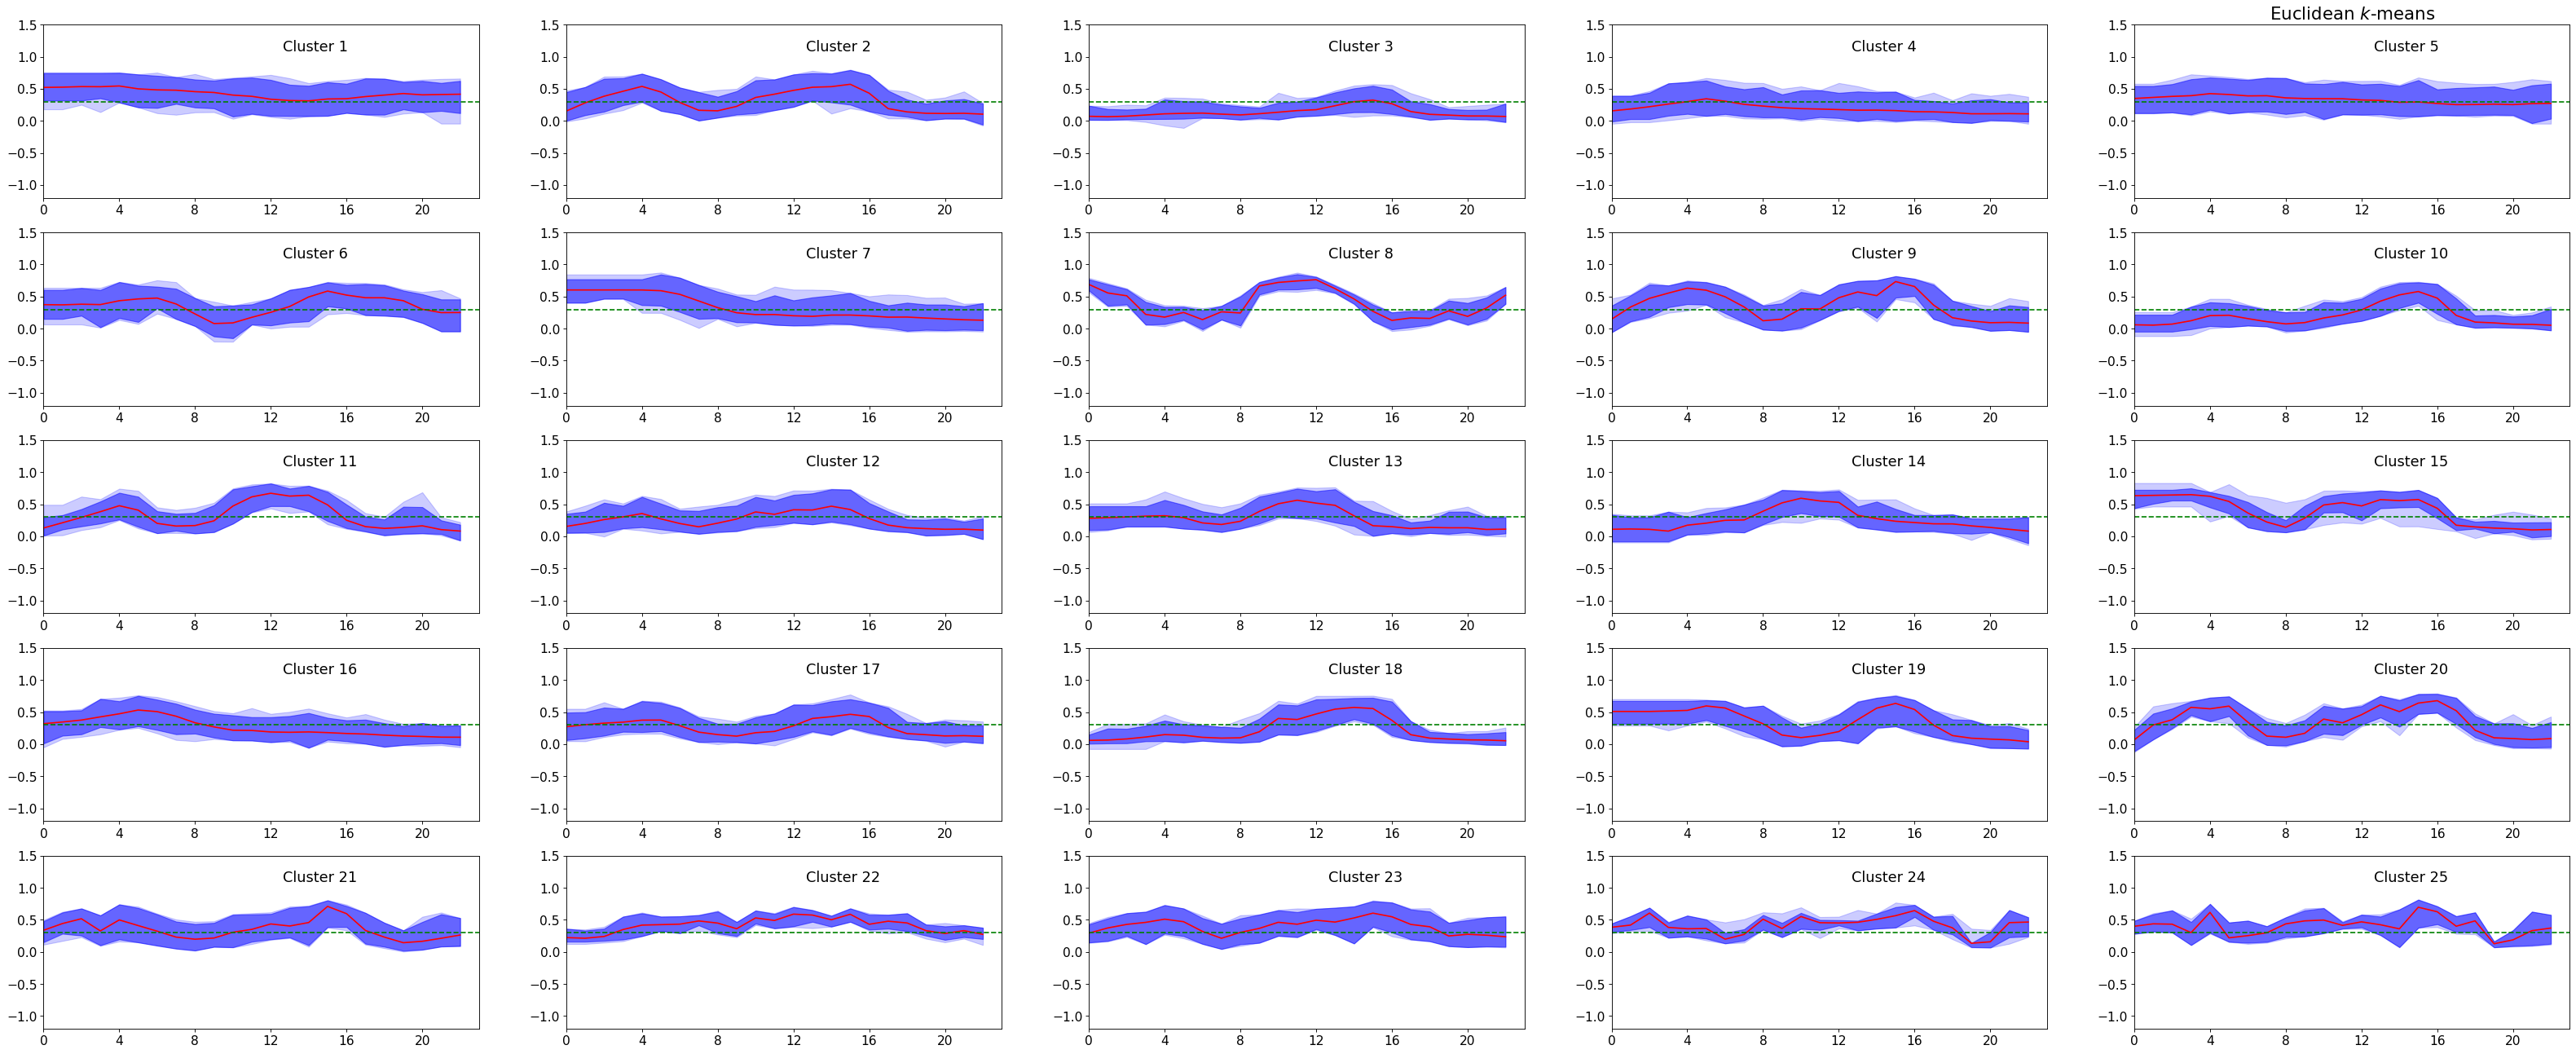

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Non_Padded_Original_NDVI_TS_L7_only.csv'
choice = 2
NUM_CLUSTERS = 21
THRESHOLD = 0.23
N_CLUSTER_SPLIT = 2

COLUMNS = []
for i in range(0, 23):
  label = str(i) + "_gapfilled_NDVI_lsc"
  COLUMNS.append(label)

# Read dataframe
df = pd.read_csv(INPUT_PATH)
df = df[COLUMNS]

ts_dataset = convert_df_to_tsdf(df, COLUMNS)

if (choice == '1'):
  km, NUM_CLUSTERS = get_clusters_from_checkpoint(KM_PATH)
else:
  km = get_initial_clusters(ts_dataset, NUM_CLUSTERS, seed=0)
  print("Number of Clusters:", len(np.unique(km.labels_)))

centroids, data_splits = get_hierarchical_clusters(ts_dataset, km, NUM_CLUSTERS, THRESHOLD, N_CLUSTER_SPLIT, seed=0)

display_clusters(centroids, data_splits, sz=ts_dataset.shape[1])

Number of centroids are:  26


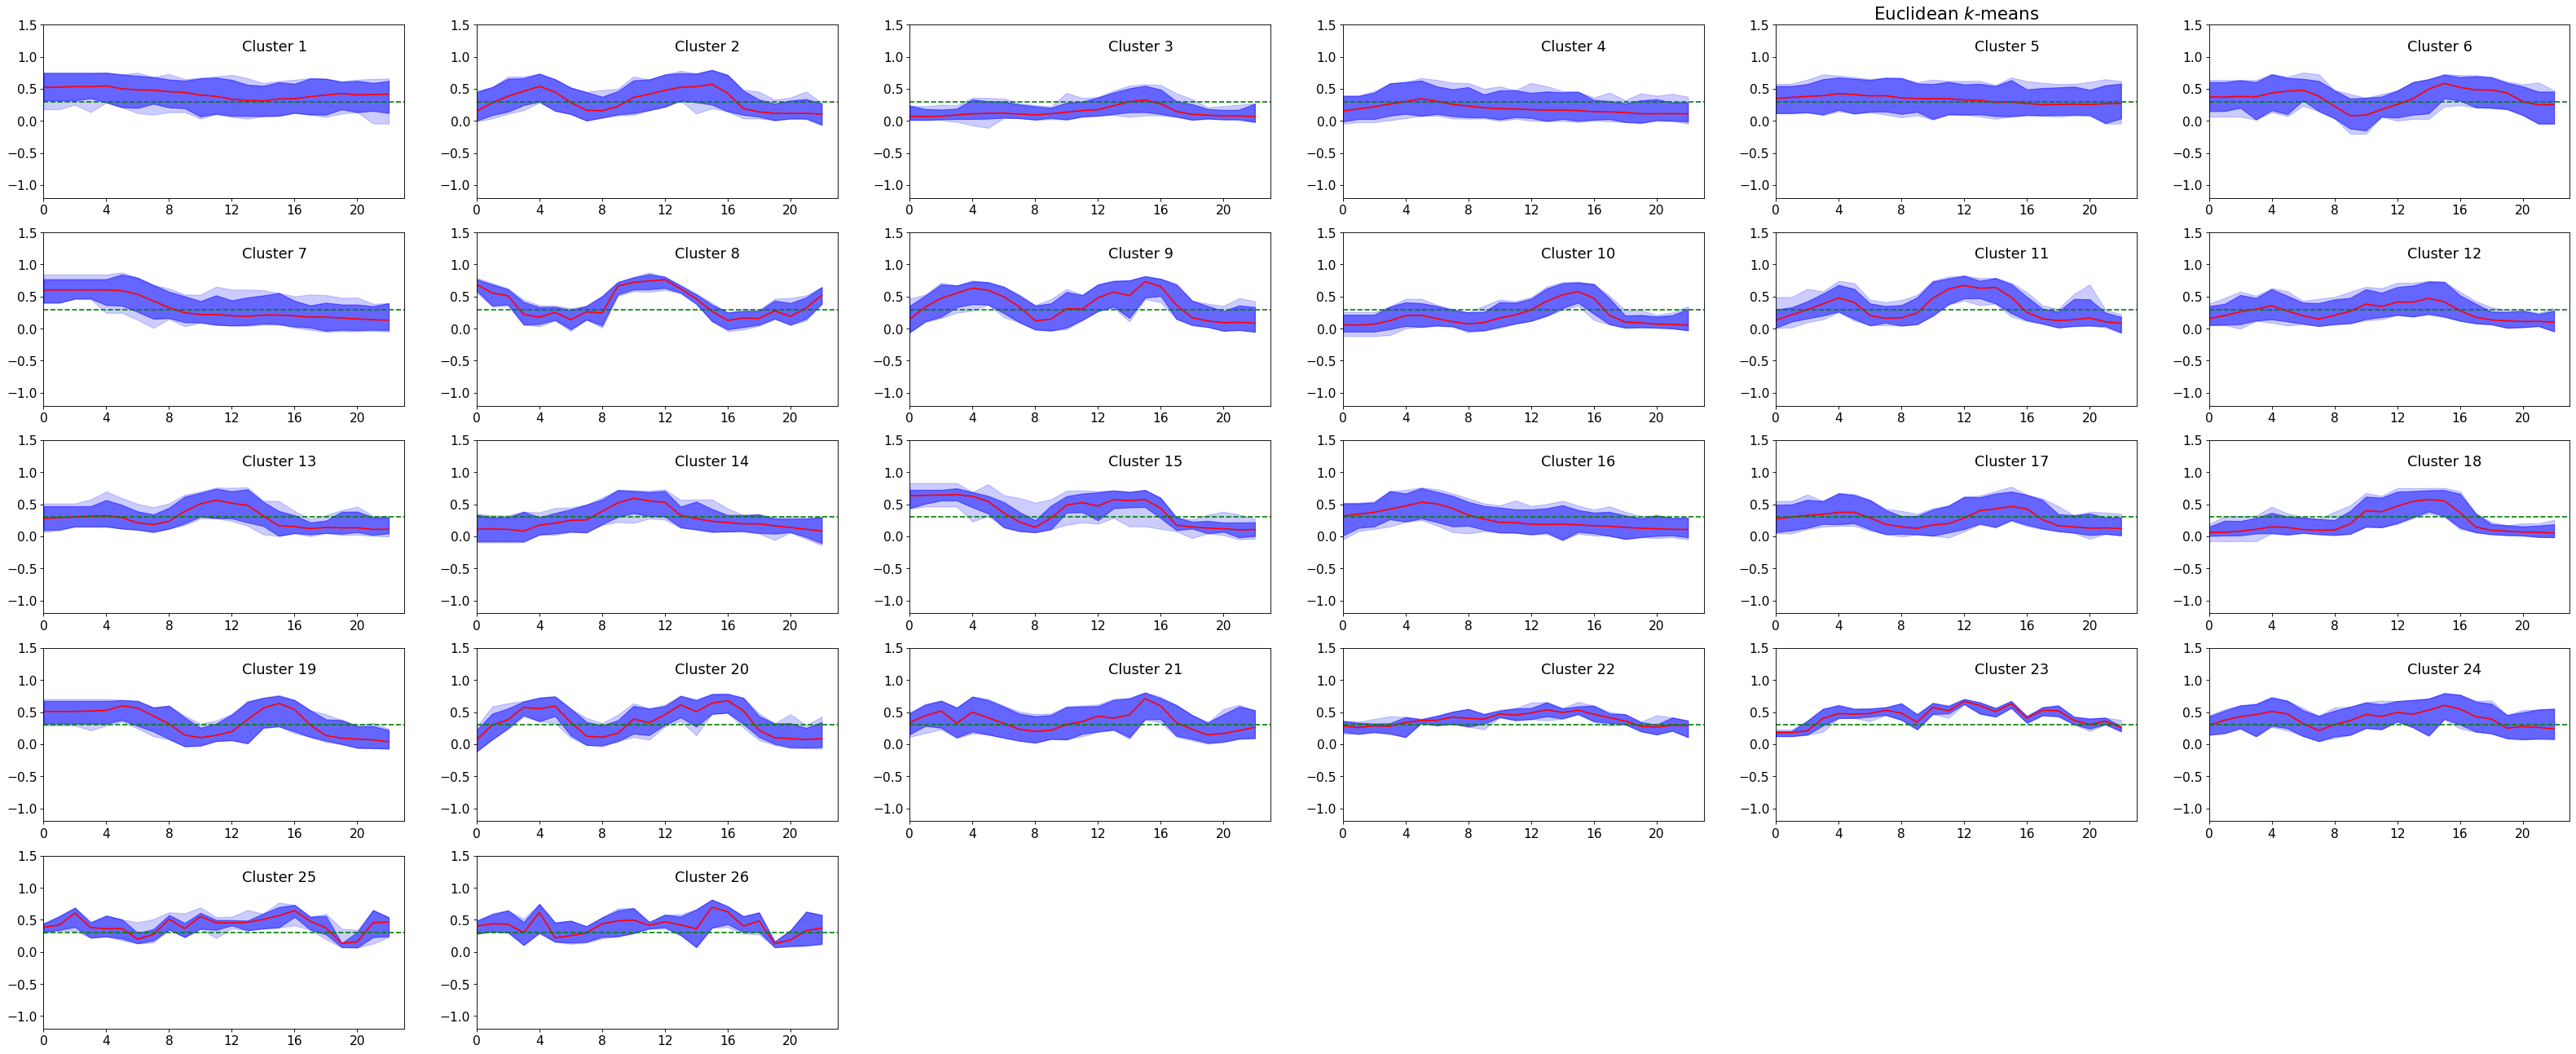

In [ ]:
# target_cluster_list = [2, 5, 8, 12, 16, 17, 18, 19, 22, 23, 24, 28, 31, 33, 35, 39, 41, 44] #for distortion 0.2
# target_cluster_list = [1, 2, 5, 8, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33]
target_cluster_list = [22]

modified_list = [x - 1 for x in target_cluster_list]

new_centroids, new_data_splits = break_target_clusters(centroids, data_splits, modified_list, seed=0)

display_clusters(new_centroids, new_data_splits, sz=ts_dataset.shape[1])

In [ ]:
# mapping = input("Enter class mapping for all clusters as space separated list \t")
# mapping = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
# mapping = 11 9 11 11 11 11 11 9 11 11 9 11 11 11 8 9 11 12 12 11 12 12 12 11 8 12 11 12 8 12 11 11
# mapping = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
# mapping = 8 8 11 8 11 11 10 8 11 11 8 9 11 9 9 11 8 8 8 11 9 9 11 8 8 8 11 8 8 12 12 12 8 8 8 12 12 13 12 8 13 12 12 8 8 8 8 12 11 8 8 8 12 12 12
'''
8 - SK
9 - SNK
10 - Double
11 - Triple
12 - Invalid
'''
mapping = "10 10 9 8 8 10 8 11 10 9 10 10 9 9 10 8 10 9 10 10 11 10 10 10 11 11"
# mapping = "1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41"

df = pd.DataFrame(np.array(new_centroids), columns=[f'{_}_gapfilled_NDVI_lsc' for _ in range(23)])

cluster_mapping = numpy.array([int(_) for _ in mapping.strip().split()])

labels = pd.Series(cluster_mapping, name= 'class')
df = pd.concat([df, labels], axis=1)

# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Non_Padded_Original_Clusters.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Non_Padded_Original_18Clusters_2distortion.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Non_Padded_Original_18Clusters_23distortion_afterCustomization.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_Original/Test_clusters.csv'
out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Eashan/Data/Non_Padded_Original_TS/Final_Level3_PanIndia_Clusters_L7_only_2018_19.csv'
df.to_csv(out_path, index=False)

# AEZ-6 Based Clusters

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_AEZ6/Non_Padded_AEZ6_NDVI_TS.csv'

COLUMNS = []
for i in range(0, 23):
    label = str(i) + "_gapfilled_NDVI_lsc"
    COLUMNS.append(label)

# Read dataframe
df = pd.read_csv(INPUT_PATH)
df = df[COLUMNS]

get_elbow_silhouette_plot(df, 2, 60)

In [ ]:
# input_path = Non_Padded_AEZ6/Non_Padded_AEZ6_NDVI_TS.csv
base_path = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data'

choice = input("\n Do you want to load initial K-Means Clustering checkpoint?  \n 1. Yes \n 2. No \n")
if (choice == '1'):
  KM_PATH = input("\n Give path to K-Means checkpoint: \t")
else:
  NUM_CLUSTERS = int(input("\n Set Number of Clusters for Initial Clustering (Recommended: 16): \t"))

THRESHOLD = float(input("\n Set Distortion Threshold for Hierarchical Step (Recommended: 0.25): \t"))
N_CLUSTER_SPLIT = int(input("\n Set Number of Clusters to be used in Hierarchical Step (Recommended: 2): \t"))
sub_path = input("\n Give path to Training Data: \t")
INPUT_PATH = base_path + '/' + sub_path

COLUMNS = []
for i in range(0, 23):
    label = str(i) + "_gapfilled_NDVI_lsc"
    COLUMNS.append(label)

Number of Clusters: 4
Processing Cluster 0
Processing Cluster 1
Processing Cluster 2
Processing Cluster 3
After Popping: 1
Processing Cluster 0
Processing Cluster 1
After Popping: 2
Processing Cluster 0
Processing Cluster 1
After Popping: 3
Processing Cluster 0
Processing Cluster 1
After Popping: 4
Processing Cluster 0
Processing Cluster 1
After Popping: 5
Processing Cluster 0
Processing Cluster 1
After Popping: 4
Processing Cluster 0
Processing Cluster 1
After Popping: 5
Processing Cluster 0
Processing Cluster 1
After Popping: 6
Processing Cluster 0
Processing Cluster 1
After Popping: 6
Processing Cluster 0
Processing Cluster 1
After Popping: 5
Processing Cluster 0
Processing Cluster 1
After Popping: 5
Processing Cluster 0
Processing Cluster 1
After Popping: 5
Processing Cluster 0
Processing Cluster 1
After Popping: 4
Processing Cluster 0
Processing Cluster 1
After Popping: 5
Processing Cluster 0
Processing Cluster 1
After Popping: 4
Processing Cluster 0
Processing Cluster 1
After Pop

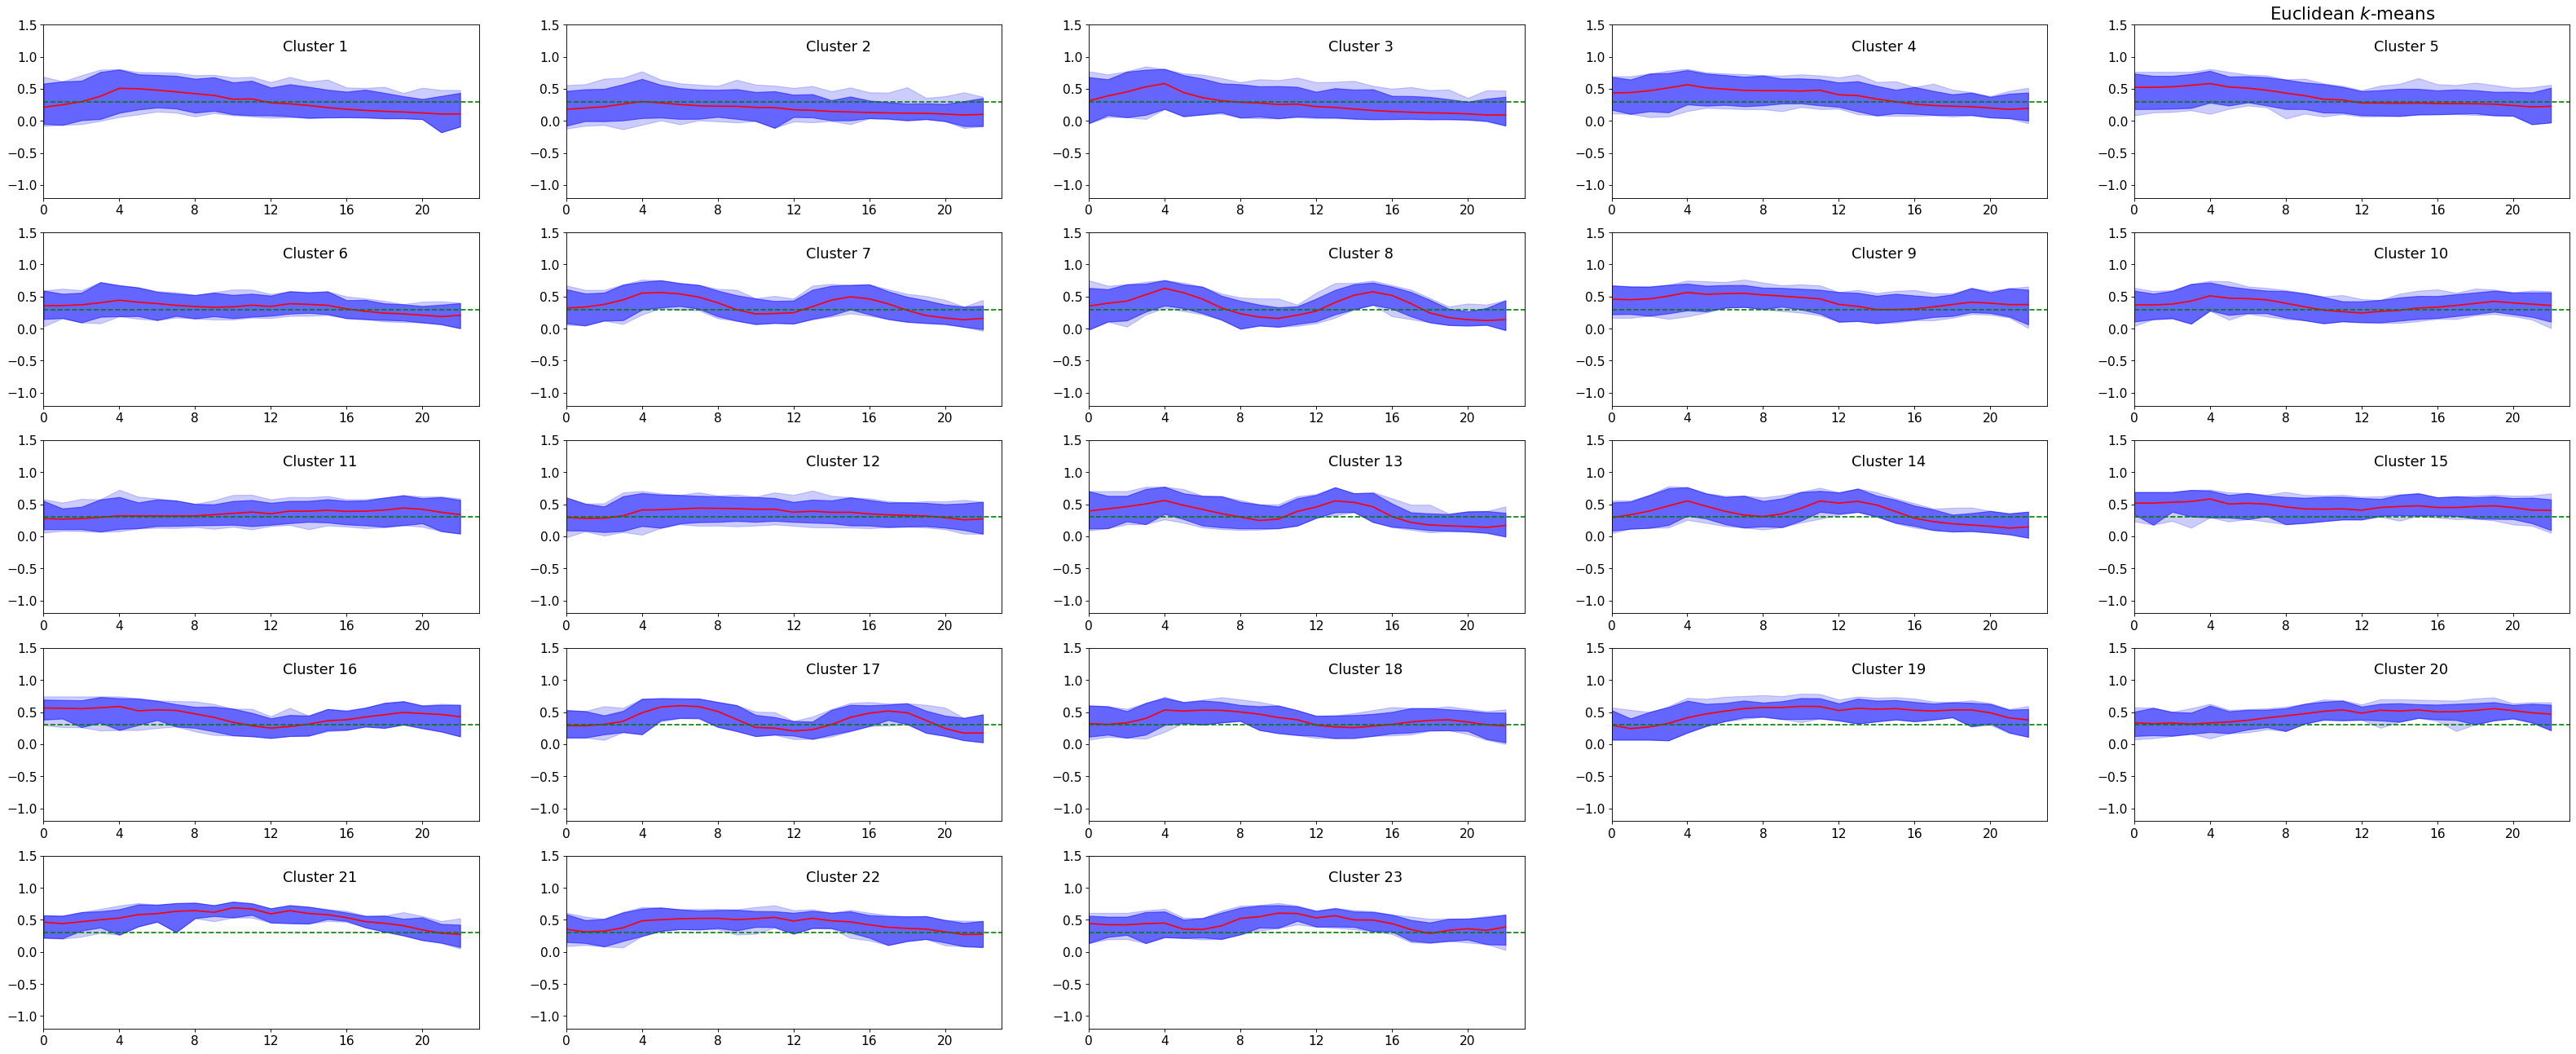

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_AEZ6/Non_Padded_AEZ6_NDVI_TS.csv'
choice = 2
NUM_CLUSTERS = 4
THRESHOLD = 0.2
N_CLUSTER_SPLIT = 2

COLUMNS = []
for i in range(0, 23):
    label = str(i) + "_gapfilled_NDVI_lsc"
    COLUMNS.append(label)

# Read dataframe
df = pd.read_csv(INPUT_PATH)
df = df[COLUMNS]

ts_dataset = convert_df_to_tsdf(df, COLUMNS)

if (choice == '1'):
  km, NUM_CLUSTERS = get_clusters_from_checkpoint(KM_PATH)
else:
  km = get_initial_clusters(ts_dataset, NUM_CLUSTERS, seed=0)
  print("Number of Clusters:", len(np.unique(km.labels_)))

centroids, data_splits = get_hierarchical_clusters(ts_dataset, km, NUM_CLUSTERS, THRESHOLD, N_CLUSTER_SPLIT, seed=0)

display_clusters(centroids, data_splits, sz=ts_dataset.shape[1])

Number of centroids are:  35


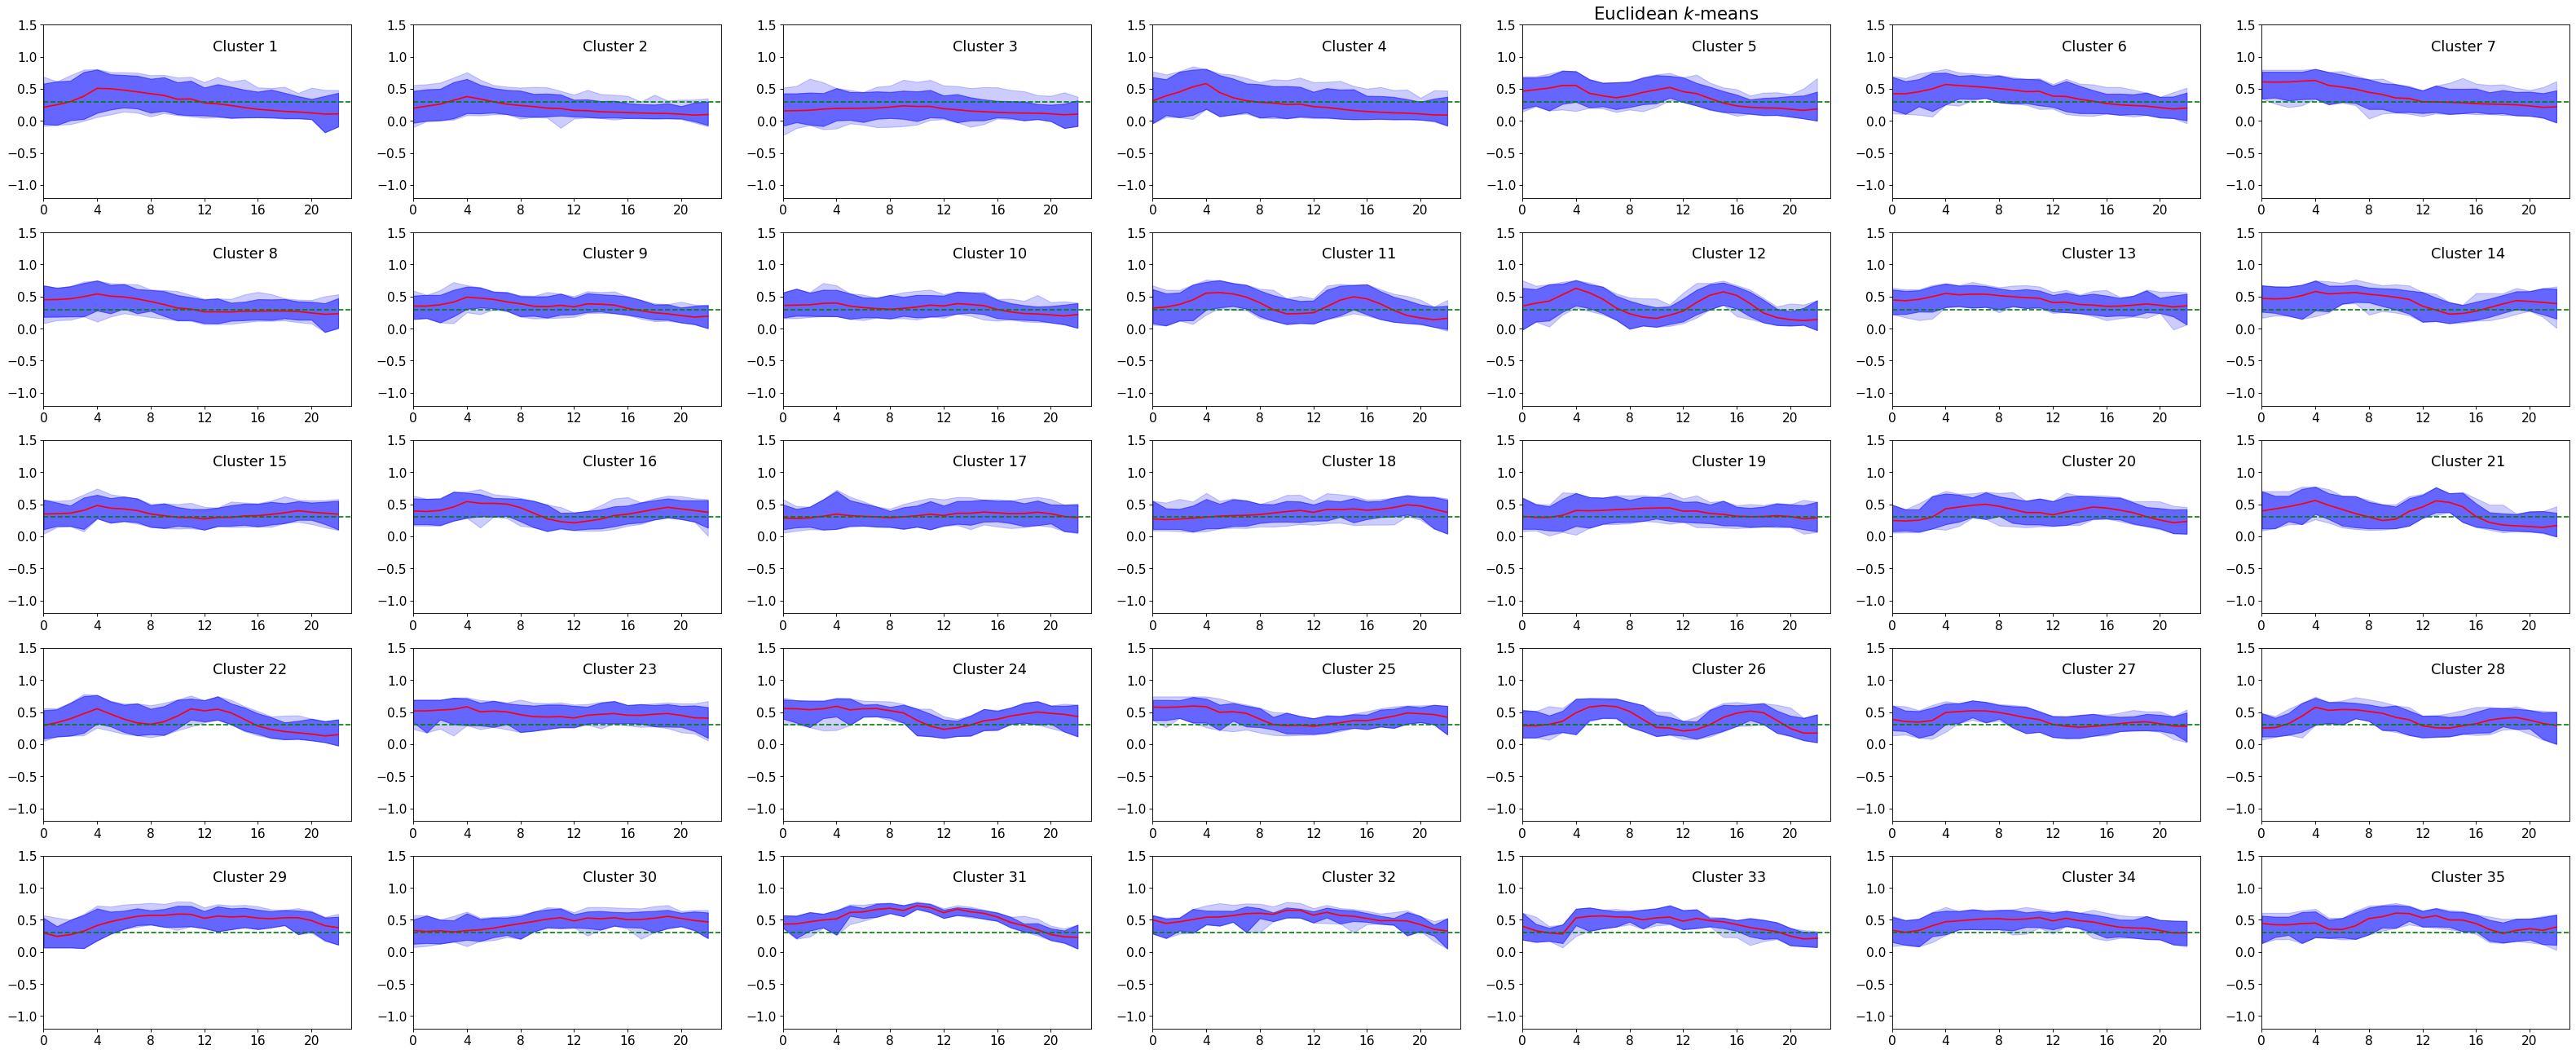

In [ ]:
# target_cluster_list = [1,2,3,4,5,6,7,9,10,11,12,13,14,17,19,23,24,25,26,27,28]
target_cluster_list = [2,4,5,6,9,10,11,12,16,18,21,22]
modified_list = [x - 1 for x in target_cluster_list]

new_centroids, new_data_splits = break_target_clusters(centroids, data_splits, modified_list, seed=0)

display_clusters(new_centroids, new_data_splits, sz=ts_dataset.shape[1])

In [ ]:
# mapping = input("Enter class mapping for all clusters as space separated list \t")
# mapping = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
# mapping = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
# mapping = 8 8 9 8 9 9 9 8 8 8 8 8 11 8 11 9 9 8 8 8 8 8 8 8 8 8 8 8 11 8 8 11 8 8 11 11 11 8 11 8 8 8 8 13 8 13 8 11 11 11 11 11
mapping = "9 9 8 9 11 9 9 9 11 8 11 11 8 12 8 12 8 8 8 11 11 11 12 12 12 11 8 12 12 12 12 12 8 12 12"

df = pd.DataFrame(np.array(new_centroids), columns=[f'{_}_gapfilled_NDVI_lsc' for _ in range(23)])
# print(df)

cluster_mapping = numpy.array([int(_) for _ in mapping.strip().split()])
# print(cluster_mapping)

labels = pd.Series(cluster_mapping, name= 'class')
# print(labels)
df = pd.concat([df, labels], axis=1)
# print(df)

# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_AEZ6/Non_Padded_AEZ6_Clusters.csv'
# out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_AEZ6/Non_Padded_AEZ6_3Clusters_0.2dist.csv'
out_path ='/content/drive/MyDrive/LULC_Experiments_Chahat_Ananjan_Saketh/Scripts/Level3_Classification_Scripts/ChahatBansal/L3_NDVI_TS_Implementation_Chahat/Non_Padded_TS_Implementation/Data/Non_Padded_AEZ6/Non_Padded_AEZ6_3Clusters_0.2dist_afterCustomization.csv'
df.to_csv(out_path, index=False)

Enter class mapping for all clusters as space separated list 	c
